# Comparison of empiral pdf and CDF for T2 and analytical  

This script looks at the observed probability of coalescing for a sample of size 2. It runs an msprime simulation then counts the number of coalesences in a time interval. This way I can compare observed T2 values against analytical results that I expect.

## Setup

Run all these cells, don't need to change anything (except maybe the parsed args)

In [2]:
# import dependencies
import os
from datetime import datetime
import argparse
from msprime_models import * 
# from abinitio_tm import scaled_time_intervals
# from msprime_utils import scaled_time_intervals, get_het, round_coal_times, tm_counts, get_coal_data, round_bin_coal_data, normalise
from msprime_utils import *
from vcf_mhs import *
import numpy as np
import pdb
import math
import pandas as pd
from scipy.stats import entropy
import argparse
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# TODO make sure this is in msprime_utils and delete from here
# TODO: this is done, so comment out and delete if no errors arise
# def num_occcurences(array,time_intervals):
#     counts = np.zeros(shape=len(time_intervals))
#     for i in range(len(array)):
#         counts[array[i]] += 1
#     return counts

In [3]:
# pecify the paramaters you want. Defaults as below

parser = argparse.ArgumentParser()
parser.add_argument("model",help="Specify the model to be used, as defined in msprime_models.")
parser.add_argument("-N","--N_0",help="Initial population size (Default is 1e+04",default=1e+04,type=int)
parser.add_argument("-L","--seq_length",help="Length of the sequence to be simulated (default 3e+07)",default=int(3e+07),type=int)
parser.add_argument("-mig","--migration_prop",help="Proportion of migrating population (default 0.3)",default=0.3,type=float)
parser.add_argument("-t","--time_splits",nargs=2,help="Time of splits, in generations (default t_1 = 2e+04, t_2 = 4e+04)",default = [int(2e+04),int(4e+04)])
parser.add_argument("-bin","--bin_length",help="The length (in bases) of the how wide you want each bin. (Default is 100)",default=100,type=int)
parser.add_argument("-o_coaldir","--output_coaldir",help="Output directory of coalescent data",default=os.getcwd() + '/coal_data/',type=str)
parser.add_argument("-o_coalname","--output_coalname",help="Output name for coal_data filename",default='',type=str)
parser.add_argument("-o_mhsdir","--output_mhsdir",help="Output dir for vcf and mhs data",default=os.getcwd() + '/vcf_mhs/',type=str)
parser.add_argument("-o_mhsname","--output_mhsname",help="Output name for vcf and mhs data",default = '',type=str)
parser.add_argument("-rho","--recomb_rate",help="Rate of recombination per bp per generation",default=2e-08,type=float)
parser.add_argument("-mew","--mut_rate",help="Rate of mutation per bp per generation",default=2e-08,type=float)
parser.add_argument("--suffix_time",help="Boolean, whether to write the time in to the files (useful for multi runs of the same simulation",action="store_true")
parser.add_argument("--print",help="Print the DemographicDebugger (from msprime) and the number of segratating sites",action="store_true")
parser.add_argument("--tree",help="Draw trees and info per segment",action="store_true")


_StoreTrueAction(option_strings=['--tree'], dest='tree', nargs=0, const=True, default=False, type=None, choices=None, help='Draw trees and info per segment', metavar=None)

In [4]:
def get_counts_freq(sim,time_intervals,args):
    # this function returns the observed pdf of T2 (f_T2(t))

    # get true coalescent data
    tmrca_data = get_coal_data(sim, args) 

    # round this data into segments of size args.bin_length 
    coal_times = round_bin_coal_data(sim,tmrca_data, args) # partition coalescent data into bins  



    # round coalescence time into interval
    coal_times_intervals = np.array(round_coal_times(coal_times,time_intervals,N_T=len(time_intervals))) # round binned coalescent times into their respected interval

    # count number of occurunces in each interval
    counts = num_occcurences(coal_times_intervals,time_intervals)

    # get frequency of these (divide by sum). This is the pdf (=f_T2(t))
    counts_freq = counts / counts.sum()
    return counts_freq



## Plots

You can now interactively specify a demograhic history, and compare T2 plots.
Fist, select the model you want (as defined in msprime_models.py.
Now you can plot the data against analytical expectation.
TODO: don't know why i have to scale the y axis for analytical expecation by len(time_intervals)/15?

### Constant population size

In [252]:
# choose model, as per msprime_models.py
print_ = True
args = parser.parse_args("m0001".split())
print("Running simulation")
sim = m0001(print_)
print("Simulation finished")

# define the time intervals
# make ntervals between time = 0 and time = 300,000 (time in generations), and set spacing
min_time = 0
max_time = 3e+05
spacing = 1000
time_intervals = np.arange(min_time,max_time,spacing)

f_cps_obs = get_counts_freq(sim,time_intervals,args) # empirical f (pdf of T_2) for constant pop size

Running simulation
Model =  hudson(reference_size=1)
Epoch: 0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Simulation finished


#### Plotting probability density 

By standard coalescent theory, the time to coalesence id exp(-t) where t=T/2N where T is discreet generations and 2N is pop size at t = 0. 

TODO: Why do I have to scale pdf with len(time_intervals)/15? The len(time_intervals) makes sense to me but dunno about 15 , something to do with sequence length surely (150e+06)

Notice we get a good fit. For the inverse coalescent rate (the population size) we have iICR = (1-F)/2f from Mazet 2016. The factor of two appears on the denominator because in his formulations they use pop size as N, where we use 2N. 

If we scale f by len(time_intervals)/15 then we get iCR as 10 and 20, which is the right shape (note that this is what we observe from the emprical distribution too) but a factor of 1000 out. If we don't divide by len(time_intervals)/15 then we get the relative iCR/N(0) (1 and 2 in this case) which seems more appropriate to me. 

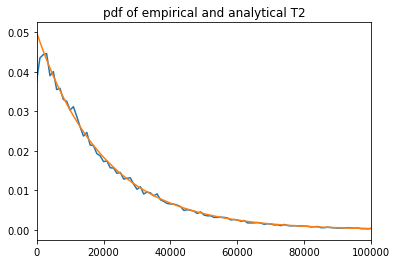

In [253]:


def f_cps(x):
    # function for analytical pdf of constant pop size
    y = np.exp(-(x)/(2*1e+04))/(len(time_intervals)/15) # TODO: why does scaling by time_interval.length/15 work? That doesn't make sense to me
    return y

x = np.arange(0,max_time,1) # array of time
y = f_cps(x) 
plt.plot(time_intervals,f_cps_obs)
plt.plot(x,y)
plt.xlim(0,100000)
plt.title("pdf of empirical and analytical T2")
plt.show()




Constant population size, no growth or migration. f_T2(t) = exp(-t) where t=T/2N where T is discreet generations and 2N is pop size (check msprime model).

Now we plot the CDF. Simply, we integrate from 0 to t the pdf, which gives F(t) = 1 - exp(-t).  Notice that we get a good fit.

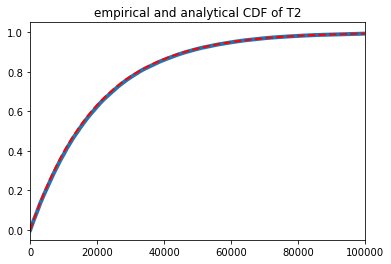

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in double_scalars


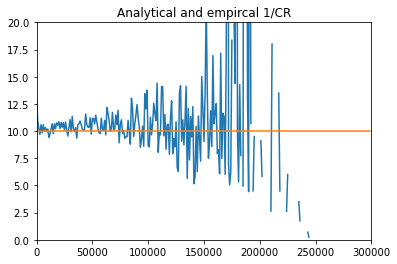

In [273]:
F_cps_obs = [sum(counts_freq[0:t]) for t in range(len(counts_freq))] # this returns the empirical CDF for a constant pop size
plt.plot(time_intervals,F_cps_obs,lw=4)
plt.title("empirical and analytical CDF of T2")
plt.xlim(0,100000)
# plt.show()

def F_cps(x):
    # analytical CDF for a constant pop size
    y = 1 - np.exp(-(x)/(2e+04))
    return y
x = np.arange(0,max_time,spacing)
y = F_cps(x)
# y = 1 - np.exp(-(x)/(2*1e+04))
plt.plot(x,y,linestyle ='dashed',color = "red",lw=2)
plt.show()

# CR = [(1-F_T2[i])/(counts_freq[i]) for i in range(len(counts_freq)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)
CR_obs = [(1-F_cps_obs[i])/(2*f_cps_obs[i]) for i in range(len(f_cps_obs)) ] # this returns the CR of the history, defined as (1-F_T2(t))/2*f_T2(t)
# the factor of 2 is necessary for the correct estimation. I think because Mazet uses N as pop size where we use N

def iCR_cps(x):
    iCR = (1-F_cps(x))/(2*f_cps(x))
    return iCR
# y_CR = (1-(1 - np.exp(-(x)/(2*1e+04))))/(2*(np.exp(-(x)/(2*1e+04))/(len(time_intervals)/15)))
# y_CR = (1-(1 - np.exp(-(x)/(2*1e+04))))/np.exp(-(x)/(2*1e+04))

plt.plot(time_intervals,CR_obs) # note numerical instability
plt.title("1/CR ")
# plt.ylim(0,20)
# plt.xlim(0,100000)
# plt.show()

x = np.arange(0,max_time,spacing)
y = iCR_cps(x)
plt.plot(x,y)
plt.title("Analytical and empircal 1/CR")
plt.xlim(0,300000)
plt.ylim(0,20)
plt.show()

### Population size that doubles at time T1

In [274]:
print_ = True
args = parser.parse_args("m0002".split())
print("Running simulation")
sim = m0002(print_)
print("Simulation finished")

Running simulation
Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  1e+04    1e+04               0 |     0    

Events @ generation 20000.0
   - Population parameter change for -1: initial_size -> 20000 
Epoch: 20000.0 -- inf generations
     start     end      growth_rate |     0    
   -------- --------       -------- | -------- 
0 |  2e+04    2e+04               0 |     0    

Simulation finished


In [275]:
# define the time intervals
# make ntervals between time = 0 and time = 300,000 (time in generations), spacing of 100
min_time = 0
max_time = 3e+05
spacing = 1000
time_intervals = np.arange(min_time,max_time,spacing)

T_1 = 20000

f_psc_obs = get_counts_freq(sim,time_intervals,args) # empirical pdf for history of population size change

#### Plotting

Again we can plot the pdf. For t <T_1 we have f(t) = exp(-t) and for t> T_1 we have exp(-T1)* exp(-t/2) where exp(-T_1) is the probability of not coalescing before T_1 and exp(-t/2) is the probability of coalescing at some time after T_1, and we divide by 2 to stretch the time to match the population expansion. Note we get a pretty good fit to the data.

TODO: again, not sure why we must scale by (len(time_intervals)/15)

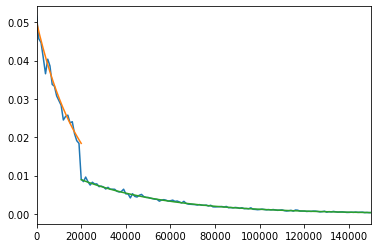

In [305]:
plt.plot(time_intervals,f_psc_obs)
# plt.show()
# .exp(-(x1)/(2*1e+04))/(len(time_intervals)/15)

def f_psc1(x):
    y = np.exp(-(x1)/(2*1e+04))/(len(time_intervals)/15)
    return y
def f_psc2(x):
    y = (np.exp(-T_1/(2*1e+04)) * np.exp(-(x2/2)/(2*1e+04)))/(len(time_intervals)/12) # TODO: why division by 12 here?
    return y

x1 = np.arange(0,T_1,1)
# y1 = np
y1 = f_psc1(x1)

x2 = np.arange(T_1,max_time)
# y2 = (np.exp(-T_1/(2*1e+04)) * np.exp(-(x2/2)/(2*1e+04)))/(len(time_intervals)/15)
y2 = f_psc2(x)

plt.plot(x1,y1)
plt.plot(x2,y2)
plt.xlim(0,max_time/2)
plt.show()

We have two cases for the CDF. For t<T_1 we have F(t) = 1-exp(-t). Then for t>T_1 we have: <br>
1-np.exp(-T_1) + exp(-T_1)*(1 - exp(-( (0.5*t) -(0.5*T_1) )) <br>
where 1-np.exp(-T_1) is the cumulative probability of coalescence before T_1, exp(-T_1) is the probability that two lineages don't coalesce before T_1, (1 - exp(-( (0.5*t) -(0.5*T_1) )) is the cumulative probability of coalescing given two uncoalesced lineages at time T_1 in a population that is double the size.

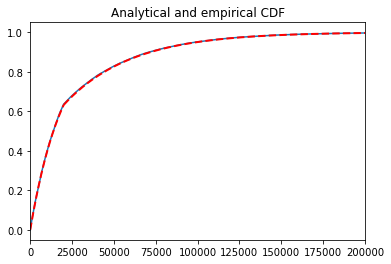

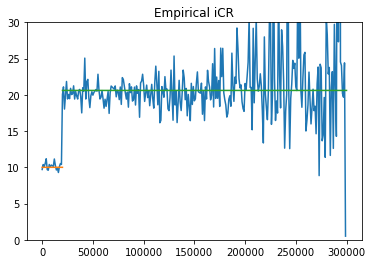

In [306]:
# plt CDF and CR

F_psc_obs = [sum(f_psc_obs[0:t]) for t in range(len(f_psc_obs))] # this returns the CDF of T2 ( F_T2(t) )
plt.plot(time_intervals,F_psc_obs)
# plt.show()

def F_psc1(x):
    y = 1 - np.exp(-(x1)/(2e+04))
    return y
def F_psc2(x):
    y = np.exp(-T_1/(2e+04))*(1 - np.exp(-( (0.5*x2)/(2e+04) -(0.5*T_1)/(2e+04) ))) + (1-np.exp(-T_1/(2e+04))) # this is correct
    return y

x1 = np.arange(0,T_1,1)
# y1 = 1 - np.exp(-(x1)/(2e+04))
y1 = F_psc1(x1)

x2 = np.arange(T_1,max_time)
y2 = F_psc2(x2)

plt.plot(x1,y1,linestyle ='dashed',color = "red",lw=2)
plt.plot(x2,y2,linestyle ='dashed',color = "red",lw=2)
plt.title("Analytical and empirical CDF")
plt.xlim(0,200000)
plt.show()

CR_psc_obs = [(1-F_psc_obs[i])/(2*f_psc_obs[i]) for i in range(len(f_psc_obs)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)
plt.plot(time_intervals,CR_psc_obs)
plt.title("Empirical iCR")
# plt.show()

def CR_psc1(x):
    CR = (1-F_psc1(x))/(2*f_psc1(x))
    return CR
def CR_psc2(x):
    CR = (1-F_psc2(x))/((2*f_psc2(x)))
    return CR
plt.plot(x1,CR_psc1(x1))
# plt.plot(x2,CR_psc2(x2))
# plt.plot(x2,(1-F_psc2(x2))/(2*f_psc2(x2)))
plt.plot(x2,CR_psc2(x2))
plt.ylim(0,30)
plt.show()

# analytical_CR = 

### Population structure (constant)

With continuous migration (n-island model), occuring at some time interval (between T1 and T2)

In [307]:
print_ = True
args = parser.parse_args("const_mig0003".split())
print("Running simulation")
sim = const_mig0003(print_)
print("Simulation finished")

Running simulation
Demographic history:

Model =  hudson(reference_size=1)
Epoch: 0 -- 20000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0        0    
1 |  1e+04    1e+04               0 |     0        0    

Events @ generation 20000.0
   - Migration rate change for (0, 1) to 0.004
   - Migration rate change for (1, 0) to 0.004
Epoch: 20000.0 -- 40000.0 generations
     start     end      growth_rate |     0        1    
   -------- --------       -------- | -------- -------- 
0 |  1e+04    1e+04               0 |     0      0.004  
1 |  1e+04    1e+04               0 |   0.004      0    

Events @ generation 40000.0
   - Migration rate change for (0, 1) to 0
   - Migration rate change for (1, 0) to 0
   - Mass migration: Lineages moved with probability 1 backwards in time with source 0 & dest 1
                     (equivalent to migration from 1 to 0 forward

In [438]:
# define the time intervals
# make ntervals between time = 0 and time = 300,000 (time in generations), spacing of 100
min_time = 0
max_time = 3e+05
spacing = 1000
time_intervals = np.arange(min_time,max_time,spacing)

T_1 = 20000

f_np_obs = get_counts_freq(sim,time_intervals,args) # empirical pdf for non panmictic history, with constant structure and constant size

In [439]:
n = 2

# N is constant size of each island
N = 10000

# Nm is the number of genes in each island every generation
# So let's say Nm = 10, then m = 10/N = 0.001
m = 0.00004

# then by definition M/2 = Nm, we have 
M = N*m*2

# total number of genes is Nn
Nn = N*n

# set mutation rate as 2 * e-08
mu = 2e-08

# then population mutation rate is 2*N*n*mu
theta = 2*N*n*mu

# so, by Mazet (2016):
gamma = M/(n-1)

# discriminant of theta^ + theta(1-n*gamma) + gamma is:
delta = (1+n*gamma)**2 - 4*gamma

# alpha 
alpha = 0.5*(1+n*gamma + np.sqrt(delta))

# beta is
beta = 0.5*(1+n*gamma - np.sqrt(delta))

# then a and c
a = (gamma - alpha)/(beta-alpha)
c = gamma/(beta - alpha)

print(f'a, c, alpha, beta, gamma is {a,c,alpha,beta,gamma}')


a, c, alpha, beta, gamma is (0.76499947000159, -0.423999152002544, 2.2433981132056604, 0.3566018867943396, 0.8)


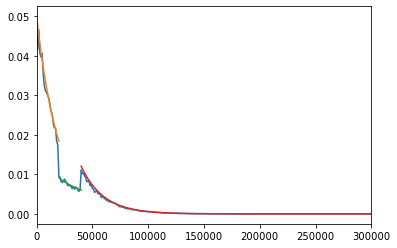

In [538]:
T_1 = 20000
T_2 = 40000

def f_np1(x):
    y = np.exp(-x/2e+04)/(len(time_intervals)/15)
    return y

def F_np1(x):
    y = 1-np.exp(-x/2e+04)
    return y

def f_samedeme(x,a,alpha,beta):
    f = a*np.exp(-alpha*(x/2e+04)) + (1-a)*np.exp(-beta*(x/2e+04))
    return f
def f_diffdeme(x,c,alpha,beta):
    f = c*np.exp(-alpha*(x/2e+04)) - c*np.exp(-beta*(x/2e+04))
    return f

def f_np2_same(x,a,c,alpha,beta,T_1):
    y = (1-F_np1(T_1))*(f_samedeme(x,a,alpha,beta))
    return y
def f_np2_diff(x,a,c,alpha,beta,T_1):
    y = (1-F_np1(T_1))*(f_diffdeme(x,a,alpha,beta))
    return y
def f_np2(x,a,c,alpha,beta,T_1):
    y = (1-F_np1(T_1))*(f_samedeme(x,a,alpha,beta) + f_diffdeme(x,c,alpha,beta))
    return y
def F_np2(x,a,c,alpha,beta,T_1):
    F = 1-np.exp(-T_1/2e+04) + 0.5*np.exp(-T_1/2e+04)*(
     (-a/alpha)*np.exp(-alpha*(x-T_1)/2e+04) -((1-a)/beta)*np.exp(-beta*(x-T_1)/2e+04) - (c/alpha)*np.exp(-alpha*(x-T_1)/2e+04) + (c/beta)*np.exp(-beta*(x-T_1)/2e+04)
        -(-a/alpha - (1-a)/beta -c/alpha + c/beta)
    )
    return F
def f_np3(x,a,c,alpha,beta,T_1):
    y = (1-F_np2(T_2,a,c,alpha,beta,T_1))*(np.exp(-(x-T_2)/2e+04))
    return y
def F_np3(x,a,c,alpha,beta,T_1,T_2):
    y = (F_np2(T_2,a,c,alpha,beta,T_1)) + (1-F_np2(T_2,a,c,alpha,beta,T_1))*(1-np.exp(-(x-T_2)/2e+04))
    return y
def CR_np1(x):
    y = (1-F_np1(x))/(2*f_np1(x))
    return y
def CR_np2(x,a,c,alpha,beta,T_1):
    y = (1-F_np2(x,a,c,alpha,beta,T_1))/(2*f_np2(x,a,c,alpha,beta,T_1)/((len(time_intervals)/15)))
    return y
def CR_np3(x,a,c,alpha,beta,T_1,T_2):
    y = (1-F_np3(x,a,c,alpha,beta,T_1,T_2))/(2*f_np3(x,a,c,alpha,beta,T_1)/((len(time_intervals)/15)))
    return y

# def F_np2(x,a,c,alpha,beta,T_1):
# #     F = 1-np.exp(-T_1/2e+04) + np.exp(-T_1/2e+04)*(1-np.exp(-(x-T_1)/(2e+04) ))
#     F = 1-np.exp(-T_1/2e+04) + np.exp(-T_1/2e+04)*(
#     (-a/alpha)*np.exp(-alpha*(x-T_1)/(2e+04)) - ((1-a)/beta)*np.exp(-beta*(x-T_1)/(2e+04)) -(c/alpha)*np.exp(-alpha*(x-T_1)/2e+04) + (c/beta)*np.exp(-beta*(x-T_1)/(2e+04))+1
#     )
#     return F


x1 = np.arange(0,T_1,1)
# y1 = np.exp(-(x1)/(2*1e+04))/(len(time_intervals)/15)
y1 = f_np1(x1)
x2 = np.arange(T_1,T_2,1)
x3 = np.arange(T_2,max_time,1)


# f_same <- function(t,a,alpha,beta){
#   f = a*exp(-alpha*t) + (1-a)*exp(-beta*t)
#   return(f)
# }

# f_diff <- function(t,c,alpha,beta){
#   f = c*exp(-alpha*t) - c*exp(-beta*t)
#   return(f)
# }
    
    
    
# def f_np2(x):
#     y = (1-)

# (1-e1_F(s1)) * f_diff_same(t,a,c,alpha,beta)


# x2 = np.arange(T_1,max_time)
# y2 = np.exp(-T_1/(2*1e+04)) * np.exp(-(x2/2)/(2*1e+04))/(len(time_intervals))
plt.plot(time_intervals,f_np_obs)
plt.plot(x1,y1)
# plt.plot(x2,f_np2_same(x2,a,c,alpha,beta,T_1)/(len(time_intervals)/5))
plt.plot(x2,f_np2(x2,a,c,alpha,beta,T_1)/(len(time_intervals)/15))
plt.plot(x3,f_np3(x3,a,c,alpha,beta,T_1)/(len(time_intervals)/15))

plt.xlim(0,max_time)
plt.show()

# plt.plot(x2,f_np2(x2,a,c,alpha,beta,T_1))
# plt.show()

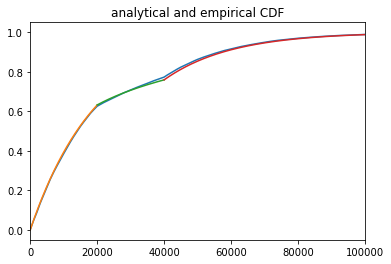

/home/trevor/miniconda3/envs/ancestry/lib/python3.6/site-packages/ipykernel_launcher.py:37: RuntimeWarning: divide by zero encountered in double_scalars


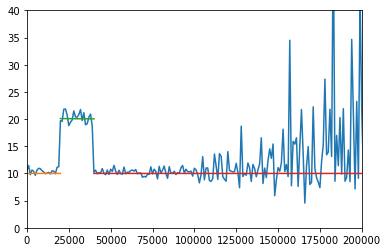

In [543]:
# plt CDF and CR



# the below is working quite well
# def F_np2(x,a,c,alpha,beta,T_1):
# #     F = 1-np.exp(-T_1/2e+04) + np.exp(-T_1/2e+04)*(1-np.exp(-(x-T_1)/(2e+04) ))
#     F = 1-np.exp(-T_1/2e+04) + np.exp(-T_1/2e+04)*(
#      -(a/alpha)*np.exp(-alpha*(x-T_1)/(2e+04)) -((1-a)/beta)*np.exp(-beta*(x-T_1)/(2e+04)) -(c/alpha)*np.exp(-alpha*(x-T_1)/2e+04) - (c/beta)*np.exp(-beta*(x-T_1)/(2e+04))
#     )
#     return F

F_np_obs = [sum(f_np_obs[0:t]) for t in range(len(f_np_obs))] # this returns the CDF of T2 ( F_T2(t) )
plt.plot(time_intervals,F_np_obs)
# plt.show()
plt.plot(x1,F_np1(x1))
# plt.plot(x2,F_np2(x2,a,c,alpha,beta,T_1))
plt.plot(x2,F_np2(x2,a,c,alpha,beta,T_1))
plt.plot(x3,F_np3(x3,a,c,alpha,beta,T_1,T_2))
plt.xlim(0,100000)
plt.title("analytical and empirical CDF")
plt.show()

# plt.plot(x2,inside(x2,a,c,alpha,beta,T_1))
# plt.title("inside function")
# plt.show()

# plt.plot(x2,inside_not(x2,a,c,alpha,beta,T_1))
# plt.title("inside not function")
# plt.show()


# plt.show()



CR_np_obs = [(1-F_np_obs[i])/(2*f_np_obs[i]) for i in range(len(f_np_obs)) ] # this returns the CR of the history, defined as (1-F_T2(t))/f_T2(t)
plt.plot(time_intervals,CR_np_obs)
plt.ylim(0,40)
plt.xlim(0,200000)
plt.plot(x1,CR_np1(x1))
plt.plot(x2,CR_np2(x2,a,c,alpha,beta,T_1))
plt.plot(x3,CR_np3(x3,a,c,alpha,beta,T_1,T_2))
plt.ylim(0,40)
plt.show()

In [348]:
print(F_cps_obs[150])
print(f_cps_obs[150])
print((1 - F_cps_obs[150]) / 2*f_cps_obs[150])
print('hello')

0.9994700000000002
2.9333333333333333e-05
7.773333333330523e-09
hello


In [363]:
((-a/alpha)-(1-a)/beta - c/alpha + c/beta)


-2.0000000000000004

In [407]:
beta

0.3566018867943396

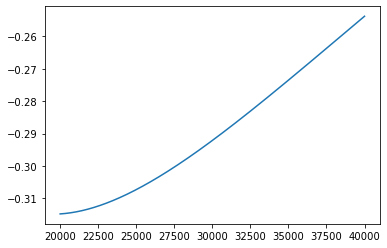

In [421]:
# (-(a/alpha)*np.exp(-alpha*(x)/(2e+04)) -((1-a)/beta)*np.exp(-beta*(x)/(2e+04)) +(c/alpha)*np.exp(-alpha*(x)/2e+04) - (c/beta)*np.exp(-beta*(x)/(2e+04)))

plt.plot(x2,-(-(a/alpha)*np.exp(-alpha*(x2)/(2e+04)) -((1-a)/beta)*np.exp(-beta*(x2)/(2e+04)) +(c/alpha)*np.exp(-alpha*(x2)/2e+04) - (c/beta)*np.exp(-beta*(x2)/(2e+04))))

In [449]:
sum(f_np2(x2,a,c,alpha,beta,T_1)/(len(time_intervals)/15))


148.0575146944466